# Introdução

In [21]:
import pandas as pd
from pulp import *
import numpy as np
import math
import random
import time
import csv
import matplotlib.pyplot as plt



In [22]:
def distL2(loc,city1,city2):
    x1, y1 = loc['Latitude'][city1], loc['Longitude'][city1]
    x2, y2 = loc['Latitude'][city2], loc['Longitude'][city2]
    xdiff = x2 - x1
    ydiff = y2 - y1
    return math.sqrt(xdiff*xdiff + ydiff*ydiff)

In [10]:
loc1 = pd.read_csv("Desktop/points2.csv")
LOCATIONS = loc1["Loc"].values
coord_plantas = {}
capacity = {}
demand = {}
loc1.set_index('Loc', inplace=True, drop=True)
for i in LOCATIONS:
    coord_plantas[i] = (loc1['Latitude'][i], loc1['Longitude'][i])
    capacity[i] = 30
    demand[i] = loc1['Demanda'][i]

dist = {}
for i in LOCATIONS:
    dist_aux = {}
    for j in LOCATIONS:
        dist_aux[j] = distL2(loc1,i,j)
    dist[i] = dist_aux


# Exercício 1 - Implementação do modelo

O modelo será implementado através de uma função 

    def problem(objective, max_min)
    
em que:

    objective recebe 1 ou 2. 
    
        Caso 1, a função objetivo é soma da distância entre cada planta – cliente
        Caso 2, a função objetivo é o número de plantas a serem instaladas
        
    max_min recebe "min" em caso de minimização e "max" em caso de maximização

In [23]:
def problem(objective, max_min):
    y = LpVariable.dicts("y", (LOCATIONS, LOCATIONS), 0, 1, LpBinary)
    x = LpVariable.dicts("x", LOCATIONS, 0, 1, LpBinary)

    if(max_min == 'max'):
        prob = pulp.LpProblem("Localização de Facilidades", pulp.LpMaximize)
    else:
        prob = pulp.LpProblem("Localização de Facilidades", pulp.LpMinimize)

    # Cada cliente só pode ser atendido por uma planta
    for j in LOCATIONS:
        prob += lpSum([y[i][j] for i in LOCATIONS]) == 1
    
    # Restrição de capacidade e demanda
    for i in LOCATIONS:
        prob += lpSum([demand[j] * y[i][j] for j in LOCATIONS]) <= capacity[i] * x[i]

    # Restrição dos 85 metros
    for i in LOCATIONS:
        prob += lpSum([y[i][j] for j in LOCATIONS if dist[i][j] > 85]) == 0

    # Função objetivo
    if(objective == 1):
        prob += lpSum([lpSum([dist[i][j]*y[i][j] for i in LOCATIONS]) for j in LOCATIONS])
    if(objective == 2):
        prob += lpSum([x[i] for i in LOCATIONS])

    prob.solve()

    objective1 = 0
    for i in LOCATIONS:
        for j in LOCATIONS:
            objective1 = objective1 + dist[i][j] * y[i][j].varValue
    objective2 = 0
    for i in LOCATIONS:
        objective2 = objective2 + x[i].varValue

    return objective1, objective2


In [24]:
print(problem(1, 'min'))
print(problem(2, 'min'))

(0.0, 100.0)
(3777.927664152292, 3.0)


# Exercício 2 - Soluções Nadir e Utópica

In [ ]:
Solução Utópica - melhor solução para ambos objetivos, porém desconsidera a viabilidade das funções objetivos
Solução Nadir - pior solução para ambos objetivos (maximização para problemas de minimização e vice-versa)

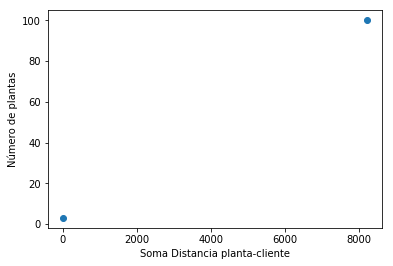

In [27]:
def utopia():
    obj11, obj12 = problem(1, 'min')
    obj21, obj22 = problem(2, 'min')
    return obj11, obj22

def nadir():
    obj11, obj12 = problem(1, 'max')
    obj21, obj22 = problem(2, 'max')
    return obj11, obj22

x = []
y = []
a,b = utopia()
x.append(a)
y.append(b)
a,b = nadir()
x.append(a)
y.append(b)
plt.scatter(x, y)
plt.xlabel("Soma Distancia planta-cliente")
plt.ylabel("Número de plantas")
plt.show()

# Exercício 3 - Método da soma ponderada

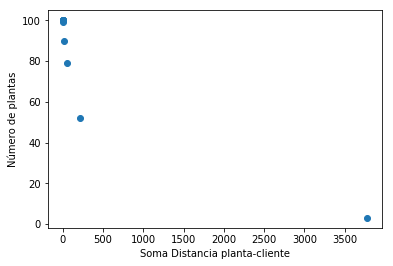

In [29]:
def wavg(weight):
    y = LpVariable.dicts("y", (LOCATIONS, LOCATIONS), 0, 1, LpBinary)
    x = LpVariable.dicts("x", LOCATIONS, 0, 1, LpBinary)

    prob = pulp.LpProblem("Localização de Facilidades", pulp.LpMinimize)

    for j in LOCATIONS:
        prob += lpSum([y[i][j] for i in LOCATIONS]) == 1

    for i in LOCATIONS:
        prob += lpSum([demand[j] * y[i][j] for j in LOCATIONS]) <= capacity[i] * x[i]

    for i in LOCATIONS:
        prob += lpSum([y[i][j] for j in LOCATIONS if dist[i][j] > 85]) == 0

    objective1 = lpSum([lpSum([weight*dist[i][j]*y[i][j] for i in LOCATIONS]) for j in LOCATIONS])
    objective2 = lpSum([(1 - weight)*x[i] for i in LOCATIONS])
    prob += objective1 + objective2

    prob.solve()

    objective1 = 0
    for i in LOCATIONS:
        for j in LOCATIONS:
            objective1 = objective1 + dist[i][j] * y[i][j].varValue
    objective2 = 0
    for i in LOCATIONS:
        objective2 = objective2 + x[i].varValue

    return objective1, objective2

w = [0.0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1.0]
x = []
y = []
sol_wavg= []
for i in w:
    a, b = wavg(i)
    x.append(a)
    y.append(b)
    sol_wavg.append((a,b))
plt.scatter(x, y)
plt.xlabel("Soma Distancia planta-cliente")
plt.ylabel("Número de plantas")
plt.show()

# Exercício 4 - Método 𝝐-restrito

In [ ]:
Esse método será implementado através de uma função 

    def econstraint(number):

Em que number é o valor da restrição aplicada a um dos objetivos.

No nosso caso, consideramos soma da distância entre cada planta – cliente como a função objetivo principal e número de plantas a serem instaladas como restrição.


In [30]:
def econstraint(number):
    y = LpVariable.dicts("y", (LOCATIONS, LOCATIONS), 0, 1, LpBinary)
    x = LpVariable.dicts("x", LOCATIONS, 0, 1, LpBinary)

    prob = pulp.LpProblem("Localização de Facilidades", pulp.LpMinimize)

    for j in LOCATIONS:
        prob += lpSum([y[i][j] for i in LOCATIONS]) == 1

    for i in LOCATIONS:
        prob += lpSum([demand[j] * y[i][j] for j in LOCATIONS]) <= capacity[i] * x[i]

    for i in LOCATIONS:
        prob += lpSum([y[i][j] for j in LOCATIONS if dist[i][j] > 85]) == 0

    prob += lpSum([x[i] for i in LOCATIONS]) <= number

    prob += lpSum([lpSum([dist[i][j]*y[i][j] for i in LOCATIONS]) for j in LOCATIONS])

    prob.solve()

    objective1 = 0
    for i in LOCATIONS:
        for j in LOCATIONS:
            objective1 = objective1 + dist[i][j] * y[i][j].varValue
    objective2 = 0
    for i in LOCATIONS:
        objective2 = objective2 + x[i].varValue

    return objective1, objective2


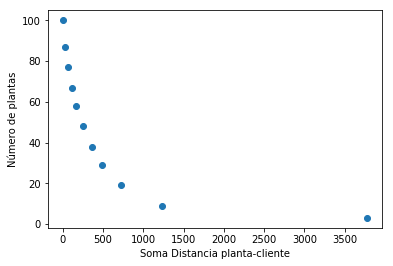

In [31]:
def p1():
    obj11, obj12 = problem(1, 'min')
    return obj11, obj12

def p2():
    obj11, obj12 = problem(2, 'min')
    return obj11, obj12

a1,b1 = p1()
a2,b2 = p2()
r = b1 - b2
pace = r/10

x = []
y = []
x.append(a1)
y.append(b1)
x.append(a2)
y.append(b2)
sol_econs = []

for i in range(1, 10):
    a, b = econstraint(i*pace)
    x.append(a)
    y.append(b)
    sol_econs.append((a,b))

plt.scatter(x, y)
plt.xlabel("Soma Distancia planta-cliente")
plt.ylabel("Número de plantas")
plt.show()


# Exercício 5 - Spacing Measure

In [32]:
def euc(p1, p2):
    xdiff = p1[0] - p2[0]
    ydiff = p1[0] - p2[1]
    return math.sqrt(xdiff*xdiff + ydiff*ydiff)

def spacing(l):
    dist = {}
    shortest = {}
    sum = 0.0
    counter = 0.0
    size = len(l)
    for i in l:
        dist_aux = {}
        min = 10000
        for j in l:
            d = euc(i, j)
            if (i != j):
                sum = sum + d
                counter = counter + 1.0
                if (d < min):
                    min = d
            dist_aux[j] = euc(i, j)
        shortest[i] = min
        dist[i] = dist_aux
    avg = sum / counter
    soma = 0
    for i in l:
        soma = soma + (1 / size) * (avg - shortest[i]) ** 2
    return math.sqrt(soma)

print("Weighed Sum Method", spacing(sol_wavg))
print("E-Constrained Method", spacing(sol_econs))

Weighed Sum Method 1599.4300774716496
E-Constrained Method 455.11586083940506
